In [10]:
## This script will walk through a basic analysis of the Acquisition and Performance data for the Data Science
## Challenge (Nov 9th and 10th 2019)
##
## Here you will find the tools necessary to open, read, and process the data as well as give you some 
## idea of the types of differing risk factors over the years. The key focus of your your analysis
## should be built around the "Zero_Bal_Cd" attribute. Look further into the script for more details
## on the different values this field can take on.
##
## In order to run this script you need to download data from this link: (you will have to create an account
## on the site but it's free)
##    https://loanperformancedata.fanniemae.com/lppub/index.html#Portfolio
##
## Additional details about these datasets (attribute names, allowable values, definitions, etc:
## is available from here:
##    https://www.fanniemae.com/portal/funding-the-market/data/loan-performance-data.html
##
## Download the data the 3rd Quarter for the years 2004, 2008, 2012, and 2016.
##
## Unzip the data files into the "RawData" directory and then execute this script.
##
## Make sure you have all the necessary python libraries listed below installed on your system
## 

In [1]:
import os
import glob
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
## print our current working directory to be sure we're operating in the right place
##
##os.getcwd()

In [3]:
## create a list of the acquisition data file names
##
all_Acq_files = glob.glob(os.path.join("RawData/Acquisition*.txt"))

In [4]:
## print out the list to make sure we've got them all
##
all_Acq_files

[]

In [65]:
## read the contents of each acquisition file into a data frame
##
df_from_each_file = (pd.read_csv(f,sep ="|", index_col=None, header=None) for f in all_Acq_files)
df   = pd.concat(df_from_each_file, ignore_index=True)

In [66]:
## The files don't have names for each column so add the columns here
##
df.rename(columns={
                    0: 'Loan_ID',
                    1: 'Channel',
                    2: 'Seller',
                    3: 'Interest_Rate',
                    4: 'UPB',
                    5: 'Loan_Term',
                    6: 'Origination_Date',
                    7: 'First_Payment_Date',
                    8: 'LTV',
                    9: 'CLTV',
                    10: 'Num_Borrowers',
                    11: 'DTI',
                    12: 'Borrower_FICO',
                    13: 'First_Time_Buyer',
                    14: 'Loan_Purpose',
                    15: 'Dwelling_Type',
                    16: 'Unit_Count',
                    17: 'Occupancy',
                    18: 'State',
                    19: 'Zip',
                    20: 'Insurance%',
                    21: 'Product',
                    22: 'Co_Borrower_FICO',
                    23: 'Mortgage_Insurance_Type',
                    24: 'Relocation_Indicator'}, inplace=True)

In [67]:
## Now grab a listing of all the performance files in the RawData directory
##
all_perf_files = glob.glob(os.path.join( "RawData/Performance_*.txt"))

In [68]:
## display a listong of the performance files to make sure the year/quarter aligns
## with the acquisition files
##
all_perf_files

['RawData/Performance_2012Q3.txt',
 'RawData/Performance_2004Q3.txt',
 'RawData/Performance_2016Q3.txt',
 'RawData/Performance_2008Q3.txt']

In [69]:
## read in the data from each of the performance files and concatenate the
## data together into a single dataframe names "perf_df" and while we're reading the data in only include
## the columns we actually want for this analysis.
##
df_from_each_file = (pd.read_csv(f,sep ="|", index_col=None, header=None
                                 ,usecols=[0,1,3,4,5,11,12]
                                 , names = ['Loan_ID', 'Period', 'Current_IR','Current_UPB', 'Age',
                                            'Mod_Ind','Zero_Bal_Cd']
                                 ,dtype = { 'Loan_ID' : np.int64, 'Current_IR' : np.float64, 
                                           'Current_UPB': np.float64}
                                ) for f in all_perf_files)
perf_df   = pd.concat(df_from_each_file, ignore_index=True)

In [70]:
## Modify the date field ("Period") to be a number for easier manipulation
## later on in the script
## 
perf_df['Period']=perf_df['Period'].apply(str).str[6:].apply(int)*100+perf_df['Period'].apply(str).str[:2].apply(int)

## Select the latest period in the data frame as we're concerned with the most recent loan status
##
idx = perf_df.groupby(['Loan_ID'])['Period'].transform(max) == perf_df['Period']

## Create a new data frame with just the latest period record
## 
perf_df_new = perf_df[idx].copy()


In [71]:
## In looking at the FAQ dor the datasets we know that if the zero balance code is null then the loan is current
## meaning it's paid up correctly. It's not late, or paid off early, or in default so we don't really care
## about those records as regards our analysis.
##
perf_df_new.Zero_Bal_Cd.fillna(0,inplace=True)

## Also, some of the loans are missing the UPB (unpaid balance). We can't use that data in building our model
## so we'll just drop those loans from the dataframe
##
perf_df_new.dropna(inplace=True)

## create a mapping of the available zero_balance_code numbers and their meanings
##
zero_bal_cd_map = {0:'Current',1:'Prepaid',2:'Third Party Sale',3:'Short Sale',
                   6:'Repurchase',9:'REO',15:'Note Sale',16:'RPL Loan Sale'}
perf_df_new['Zero_Bal_Cd'] = perf_df_new['Zero_Bal_Cd'].map(zero_bal_cd_map).apply(str)

## display a listing of the updated performance data 
##
perf_df_new.head()


,Loan_ID,Period,Current_IR,Current_UPB,Age,Mod_Ind,Zero_Bal_Cd
81,100002679724,201906,3.625,110549.80,82,N,Current
150,100003137281,201805,3.375,147781.08,68,N,Prepaid
234,100004790326,201906,4.125,219852.60,84,N,Current
268,100006404894,201504,3.000,123368.58,33,N,Prepaid
305,100008536293,201508,3.250,159596.31,36,N,Prepaid
387,100008741734,201906,3.750,135291.59,81,N,Current
469,100010567729,201906,2.875,116108.33,80,N,Current
493,100011023127,201408,4.375,107736.31,23,N,Prepaid
577,100012697764,201906,4.250,231085.49,84,N,Current
661,100013153592,201906,4.250,64765.21,83,N,Current


In [72]:
## Now that we've cleaned up the acquisition and performance data, merge them into a single integrated
## data frame that we'll call "loan_df"
##
loan_df = pd.merge(df,perf_df_new,how='inner',on='Loan_ID')

## display the first several rows from the combined dataset
##
loan_df.head()

,Loan_ID,Channel,Seller,Interest_Rate,UPB,Loan_Term,Origination_Date,First_Payment_Date,LTV,CLTV,...,Product,Co_Borrower_FICO,Mortgage_Insurance_Type,Relocation_Indicator,Period,Current_IR,Current_UPB,Age,Mod_Ind,Zero_Bal_Cd
0,100001458647,R,"CITIMORTGAGE, INC.",5.625,297000,360,05/2004,07/2004,49,61.0,...,FRM,NaN,NaN,N,201309,5.625,251567.64,111,N,Prepaid
1,100004788186,C,"BANK OF AMERICA, N.A.",5.750,50000,180,08/2004,10/2004,25,25.0,...,FRM,753.0,NaN,N,201207,5.750,12621.76,94,N,Prepaid
2,100008528816,R,OTHER,5.000,80000,180,08/2004,10/2004,75,75.0,...,FRM,678.0,NaN,N,201508,5.000,40214.78,131,N,REO
3,100014656651,C,"BANK OF AMERICA, N.A.",6.300,55000,240,07/2004,09/2004,80,80.0,...,FRM,NaN,NaN,N,201402,6.300,37473.50,114,N,Prepaid
4,100021529837,C,"BANK OF AMERICA, N.A.",5.875,140000,360,07/2004,09/2004,80,80.0,...,FRM,794.0,NaN,N,201010,5.875,119759.31,74,N,Prepaid


In [73]:
loan_df.isnull().sum()

Loan_ID                          0
Channel                          0
Seller                           0
Interest_Rate                    0
UPB                              0
Loan_Term                        0
Origination_Date                 0
First_Payment_Date               0
LTV                              0
CLTV                             4
Num_Borrowers                   65
DTI                          40037
Borrower_FICO                 3450
First_Time_Buyer                 0
Loan_Purpose                     0
Dwelling_Type                    0
Unit_Count                       0
Occupancy                        0
State                            0
Zip                              0
Insurance%                 1678310
Product                          0
Co_Borrower_FICO           1017720
Mortgage_Insurance_Type    1678310
Relocation_Indicator             0
Period                           0
Current_IR                       0
Current_UPB                      0
Age                 

In [74]:
## Assign Defaults for the missing values in the loans dataframe
##
loan_df.Mortgage_Insurance_Type.fillna(0,inplace=True)
loan_df['Insurance%'].fillna(0,inplace=True)
loan_df.Num_Borrowers.fillna(1,inplace=True)
loan_df.CLTV.fillna(loan_df.LTV,inplace=True)
loan_df.drop('Co_Borrower_FICO',axis=1,inplace=True)

In [75]:
loan_df.isnull().sum()

Loan_ID                        0
Channel                        0
Seller                         0
Interest_Rate                  0
UPB                            0
Loan_Term                      0
Origination_Date               0
First_Payment_Date             0
LTV                            0
CLTV                           0
Num_Borrowers                  0
DTI                        40037
Borrower_FICO               3450
First_Time_Buyer               0
Loan_Purpose                   0
Dwelling_Type                  0
Unit_Count                     0
Occupancy                      0
State                          0
Zip                            0
Insurance%                     0
Product                        0
Mortgage_Insurance_Type        0
Relocation_Indicator           0
Period                         0
Current_IR                     0
Current_UPB                    0
Age                            0
Mod_Ind                        0
Zero_Bal_Cd                    0
dtype: int

In [76]:
## Drop any records that still have null values - we don't want to include them in the model / analysis
##
loan_df.dropna(inplace=True)

In [79]:
## We'll do some analysis against the FICO (credit score) of the borrower
## Create several bins based on the FICO score range and add the calculated FICO bin score
## to each record in the dataframe
##
FICO_bins = [0,620,660,700,740,780,850]
FICO_labels = ['0-620', '620-660','660-700','700-740','740-780','780+']
loan_df['FICO_bins'] = pd.cut(loan_df['Borrower_FICO'],bins=FICO_bins,labels=FICO_labels)

Term_bins =[0,180,360]
Term_labels =['<=15 Years','<= 30 Years']
loan_df['Term_bins'] = pd.cut(loan_df['Loan_Term'],bins=Term_bins,labels=Term_labels)

zero_bal_cd_map = {'Current':'Current','Prepaid':'Prepaid','Third Party Sale':'Underperforming','Short Sale':'Underperforming',
                   'Repurchase':'Underperforming','REO':'Underperforming','Note Sale':'Underperforming','RPL Loan Sale':'Underperforming'}
loan_df['Current_Status'] = loan_df['Zero_Bal_Cd'].map(zero_bal_cd_map).apply(str)

loan_df['Origin_Month'],loan_df['Origin_Year'] = loan_df['First_Payment_Date'].str.split('/', 1).str

df = loan_df[loan_df['Origin_Year'].isin(['2003','2008','2012','2016'])]

In [80]:
## Build a table showing the current status and total for each status type by year
##
df.groupby(['Origin_Year','Current_Status']).agg({'Loan_ID':'count'})

Loan_ID
Origin_Year Current_Status          
2003        Current              265
            Prepaid             3759
            Underperforming       52
2008        Current            24646
            Prepaid           296382
            Underperforming    19573
2012        Current           383238
            Prepaid           330469
            Underperforming     1007
2016        Current           514154
            Prepaid           108063
            Underperforming      551

In [30]:
## Create a new dataframe that holds the first 100,000 records
##
df2 = df.groupby('Origin_Year').head(100000)

In [81]:
## display another table showing the total number of each status by year
##
df2.groupby(['Origin_Year','Current_Status']).agg({'Loan_ID':'count'})

Loan_ID
Origin_Year Current_Status          
2003        Current              265
            Prepaid             3759
            Underperforming       52
2008        Current             7212
            Prepaid            87017
            Underperforming     5771
2012        Current            53775
            Prepaid            46070
            Underperforming      155
2016        Current            82548
            Prepaid            17352
            Underperforming      100

In [82]:
## Dump some info about the attributes that make up our dataframe
##
## Out of this list of attributes, which ones (and with what values) correlate the most with prepaid and defaulted
## mortages for each of the 4 years? Is there some attribute that remains significant across all four years?
## These are the "risk factors" we're interested in having you find in the data and display in some visually
## interesting way.
##
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304076 entries, 49 to 1466311
Data columns (total 34 columns):
Loan_ID                    304076 non-null int64
Channel                    304076 non-null object
Seller                     304076 non-null object
Interest_Rate              304076 non-null float64
UPB                        304076 non-null int64
Loan_Term                  304076 non-null int64
Origination_Date           304076 non-null object
First_Payment_Date         304076 non-null object
LTV                        304076 non-null int64
CLTV                       304076 non-null float64
Num_Borrowers              304076 non-null float64
DTI                        304076 non-null float64
Borrower_FICO              304076 non-null float64
First_Time_Buyer           304076 non-null object
Loan_Purpose               304076 non-null object
Dwelling_Type              304076 non-null object
Unit_Count                 304076 non-null int64
Occupancy                  304076 non

In [84]:
## Write our current data frame out to a file. This will allow us to pick up and continue our
## analysis without going through all the previous work to clean and structure
## the data correctly.
##
df2.to_csv('Processed_loans.csv',index=False)

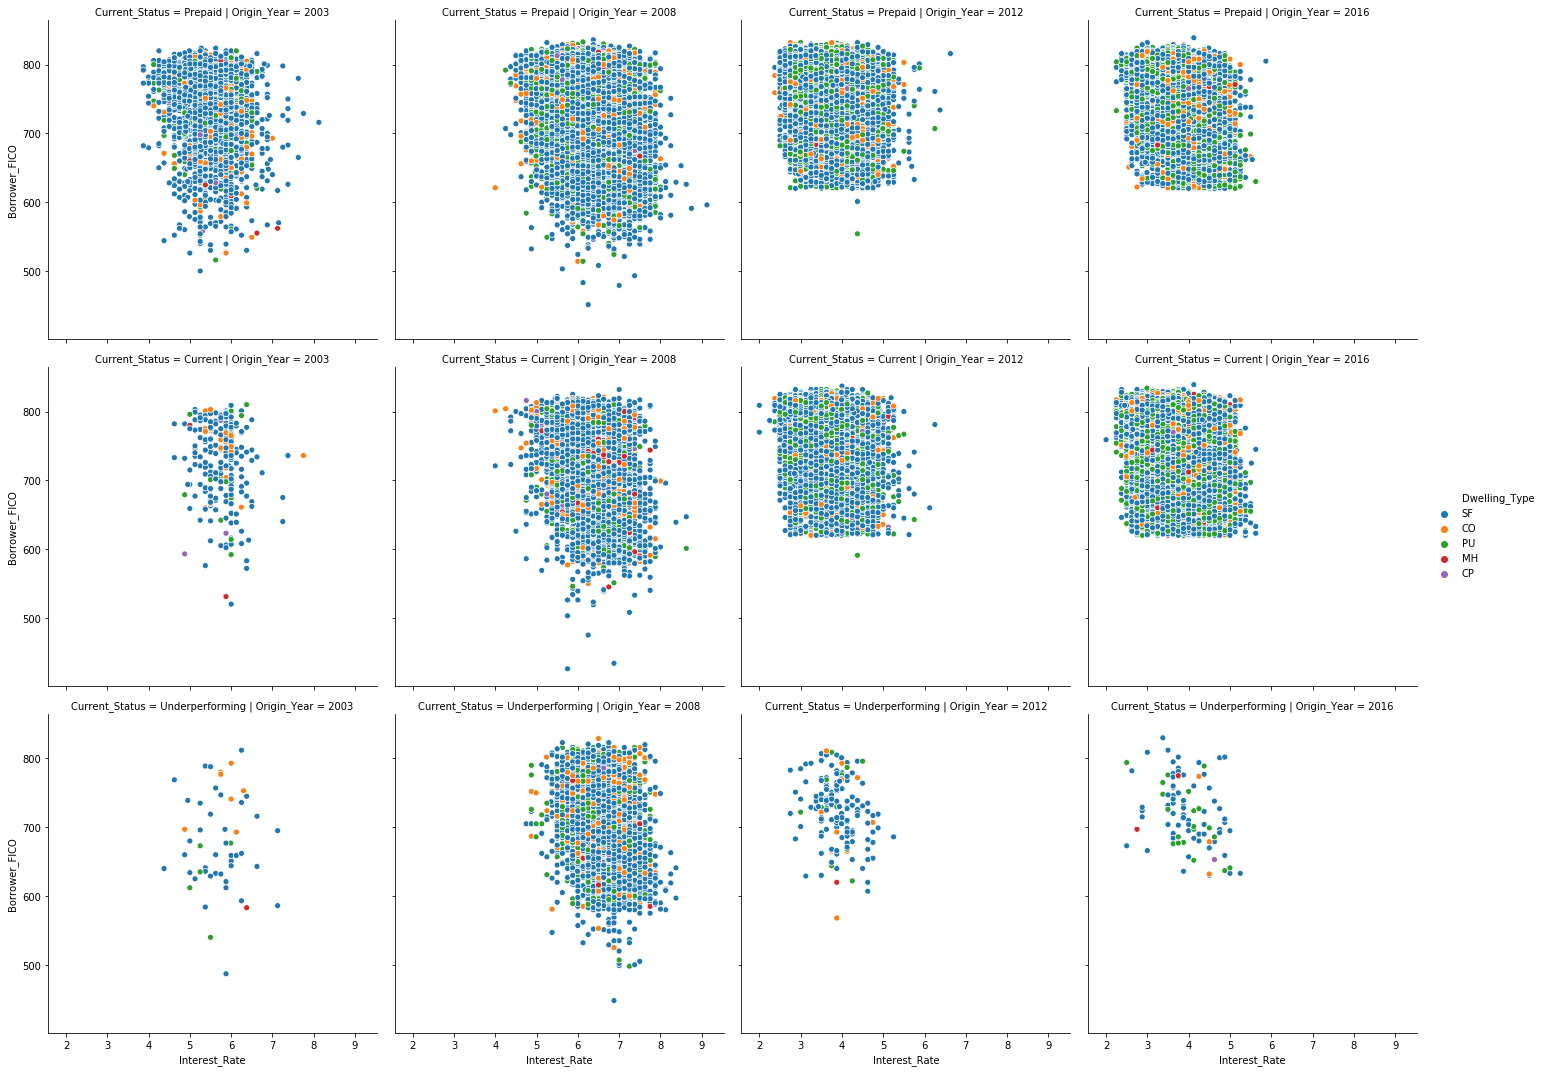

In [39]:
## Create and display a plot showing the distribution by year for the Borrower FICO score vs
## current, underperforming, and prepaid (paid off early) loans
##
sns.relplot(y='Borrower_FICO', x='Interest_Rate', data=df2
            ,hue='Dwelling_Type',
            row='Current_Status', col='Origin_Year')
plt.show()

In [85]:
## Rebalance the record set by Dwelling Type into a new data frame (df3). We're doing this because the Single
## Family data (individual family homes) is overwhelming the other types of homes (multi-family, etc) and we want
## a more balanced view of the data
##
g = df2.groupby(['Origin_Year','Dwelling_Type'])
df3 = g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True)

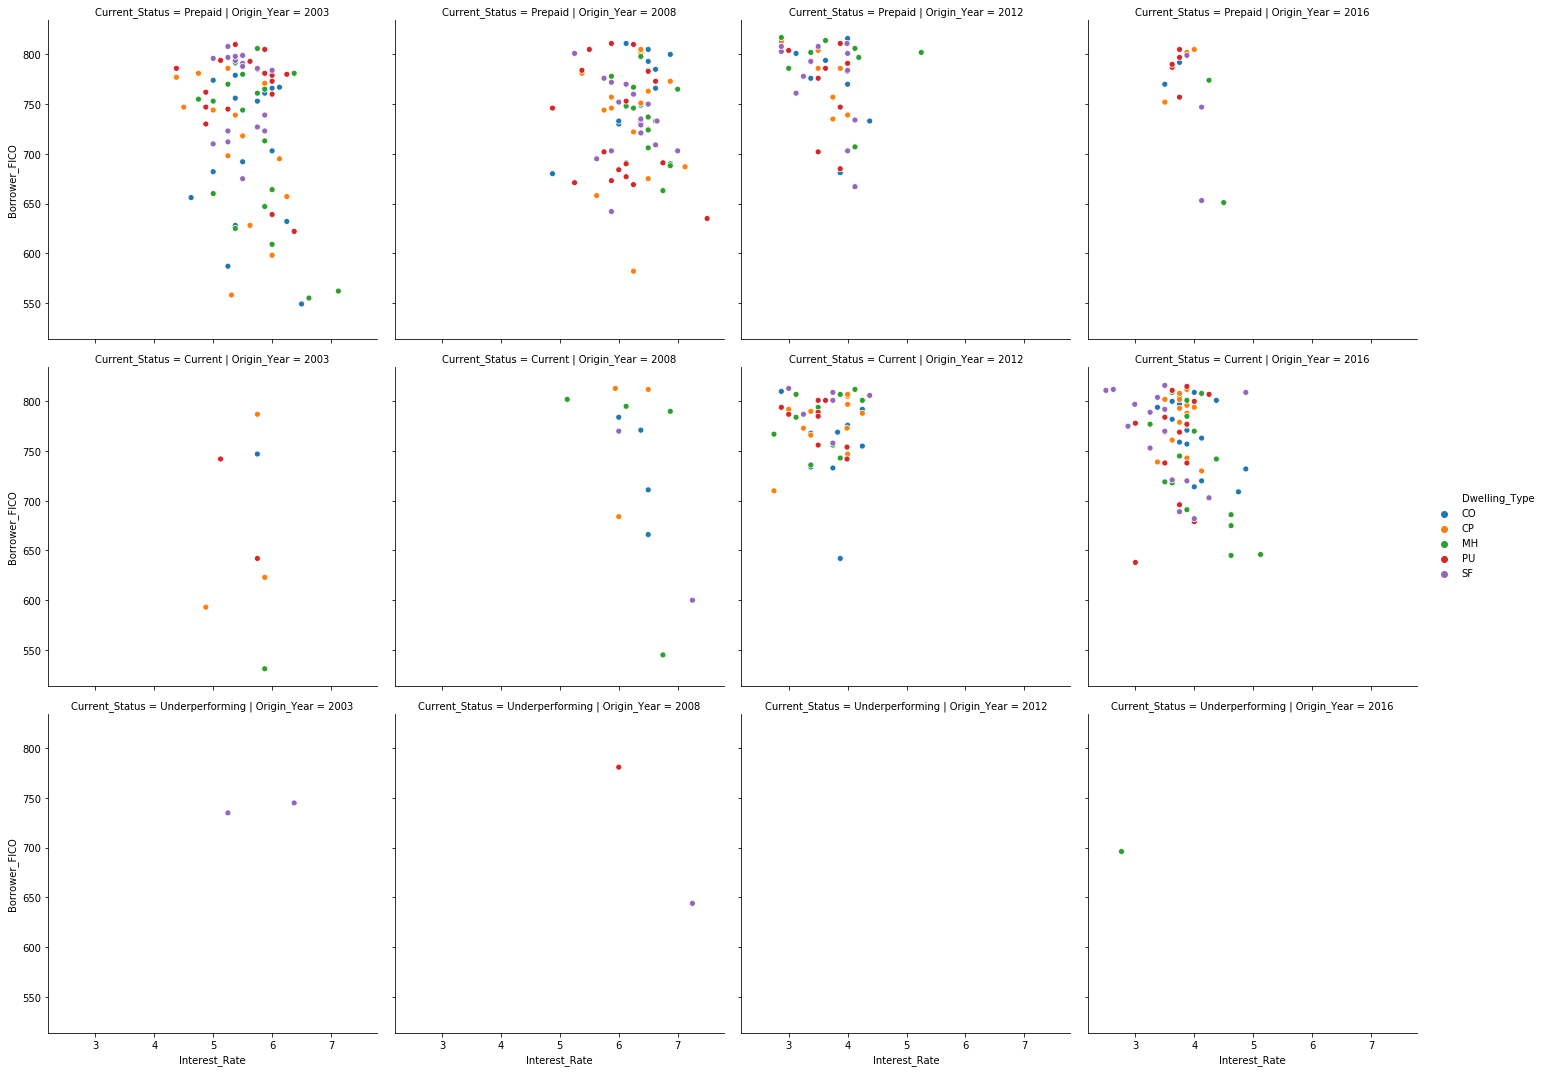

In [86]:
## Redisplay the graph based on the same attributes used above
##
sns.relplot(y='Borrower_FICO', x='Interest_Rate', data=df3#.query('Current_Status != "Prepaid"'), #kind='line', 
            ,hue='Dwelling_Type',
            row='Current_Status', col='Origin_Year')
plt.show()